In [1]:
import spacy
import torch
import networkx as nx
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel

d:\Coding\school\thesis dhewa\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


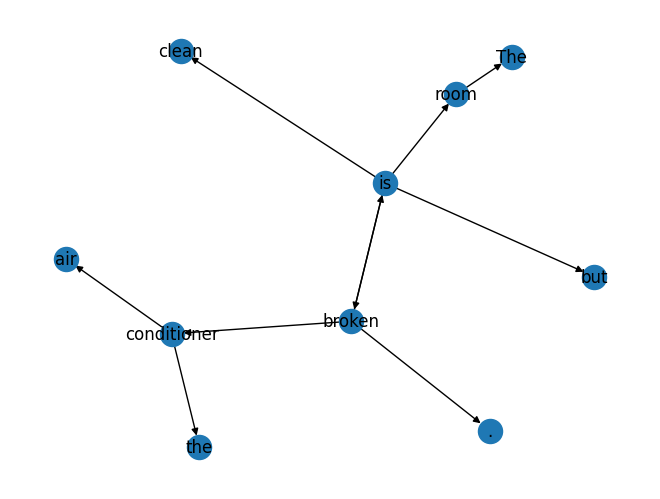

In [6]:
# Load pre-trained BERT
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")

def get_word_embedding(word):
    """Get BERT embedding for a word."""
    inputs = tokenizer(word, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1)  # (1, 768)

# Convert graph to PyTorch Geometric format
def graph_to_torch(graph):
    """Convert NetworkX graph to PyTorch Geometric format."""
    node_list = list(graph.nodes)
    
    # Map words to indices
    node_to_id = {word: i for i, word in enumerate(node_list)}

    # Convert edges to tensor format (numerical indices)
    edge_index = torch.tensor([[node_to_id[src], node_to_id[dst]] for src, dst in graph.edges()], dtype=torch.long).t().contiguous()

    # Get embeddings for each node
    node_embeddings = torch.stack([get_word_embedding(word) for word in node_list])

    # Convert to PyTorch Geometric Data format
    data = Data(x=node_embeddings.squeeze(1), edge_index=edge_index)
    return data

# Example sentence
sentence = "The hotel room was clean, but the WiFi was slow."

# Build dependency graph
def build_graph(text):
    """Build a dependency graph using spaCy."""
    import spacy
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(text)
    graph = nx.DiGraph()

    for token in doc:
        graph.add_node(token.text)  # Add words as nodes
        if token.dep_ != "ROOT":
            graph.add_edge(token.head.text, token.text)  # Add dependency edges

    return graph

graph = build_graph(sentence)

# Convert graph to PyTorch Geometric format
data = graph_to_torch(graph)

print(data)

Data(x=[11, 768], edge_index=[2, 11])


In [7]:
data

Data(x=[11, 768], edge_index=[2, 11])

In [8]:
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Initialize model
model = GCN(input_dim=768, hidden_dim=128, output_dim=3)  # 3 classes (pos/neg/neutral)

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

# Example Labels (Manually set for now)
labels = torch.tensor([2, 1, 0, 1, 2, 0, 1, 2, 0, 1, 2]) # Sentiments: positive, negative, neutral...

def train(data):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out, labels)  # Compute loss
    loss.backward()
    optimizer.step()
    return loss.item()

# Train for 50 epochs
for epoch in range(50):
    loss = train(data)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss {loss}")


Epoch 0: Loss 1.1315770149230957
Epoch 10: Loss 0.8176432251930237
Epoch 20: Loss 0.6000140905380249
Epoch 30: Loss 0.3414788842201233
Epoch 40: Loss 0.15763749182224274


In [13]:
def predict(data):
    model.eval()
    with torch.no_grad():
        out = model(data)
        return torch.argmax(out, dim=1)  # Predicted sentiment labels

pred_labels = predict(data)
print(pred_labels)

tensor([2, 1, 0, 1, 2, 0, 1, 2, 0, 1, 2])
